# BPE-Segmentation PFST

In [136]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
import numpy as np
from arsenal import colors
from collections import defaultdict, Counter
from genparse import Float, FST, EPSILON, EOS
from genparse.util import display_table, HTML
from helpers import last_char_sub_closure, prefix_closure, prefixes, suffixes, longest_suffix_in, max_munch

In [138]:
fmt = lambda x: ''.join(x) or 'ε'

In [153]:
def construction(S, alphabet, canonical, debug=True):
    assert EOS not in alphabet
    
    C = {tuple(s) for _, s in S}
    original = C | {()}

    C = set(prefix_closure(C))
    #C = set(last_char_sub_closure(alphabet, C))
    
    C = {tuple(c): ''.join(c) for c in C}

    if debug:
        _C = set(C)
        print(colors.mark(_C == original), 'added contexts:', sorted(map(fmt, _C - original)))
        assert _C >= original
    
    states = {c[:-1] for c in C}  # not the last character

    m = FST(Float)
    m.set_I((), 1)
    for p in sorted(states):
        
        for y in sorted(alphabet):
            c = p+(y,)
            
            next_states = {longest_suffix_in(c, states)} if canonical else set(suffixes(c)) & states
            
            N = len(next_states)
            for q in sorted(next_states):
                R = c[len(q):]      # "residual": a transition `abc -> c` should emit `ab`
                
                # TODO: pull this out of the loop. 
                # TODO: we can tokenize the residual string in other ways make that possible.
                mm = '|'.join(max_munch({''.join(d) for d in C})(''.join(R)))

                if debug:
                    print(f'{fmt(p)} —{y}:[{fmt(c)};{fmt(R)};{fmt(mm)}]⟶ {fmt(q)}')
                
                m.set_arc(p, (y, mm), q, 1/N)

        # we don't need the segmenter here because of prefix closure (i.e., all states p are in C)
        m.set_arc(p, (EOS, C[p]), EOS, 1)

    m.set_F(EOS, 1)
    return m

✔ added contexts: []
ε —a:[a;a;a]⟶ ε
ε —a:[a;ε;ε]⟶ a
ε —b:[b;b;b]⟶ ε
ε —c:[c;c;c]⟶ ε
a —a:[aa;aa;a|a]⟶ ε
a —a:[aa;a;a]⟶ a
a —b:[ab;ab;ab]⟶ ε
a —b:[ab;ε;ε]⟶ ab
a —c:[ac;ac;a|c]⟶ ε
ab —a:[aba;aba;ab|a]⟶ ε
ab —a:[aba;ba;b|a]⟶ a
ab —b:[abb;abb;ab|b]⟶ ε
ab —c:[abc;abc;abc]⟶ ε


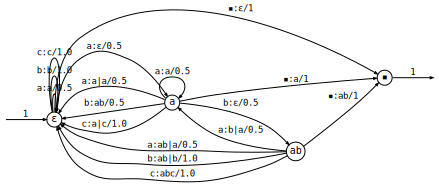

In [154]:
cc = construction([(w,w) for w in ['a', 'b', 'c', 'ab', 'abc']], set('abc'), canonical=False).trim
cc.graphviz(fmt_node=fmt)

In [155]:
def test_fst(T, x, rmeps=True):
    tmp = T(x + EOS, None)
    if rmeps: tmp = tmp.epsremove.trim
    Z = tmp.total_weight()
    print(colors.mark(np.allclose(Z, 1)), Z)
    D = tmp.to_cfg().language(100)
    display_table([[D, tmp]])
    for Y in D:
        X = ''.join(Y)
        X = X.replace('|','')
        print(colors.mark(X == x), X)
        assert X == x
    assert np.allclose(Z, 1)

In [156]:
test_strings = [
    'aa',
    'acab',
    'abc',
    'abcabc',
    'abcab',
]

In [157]:
C = cc
for x in test_strings:    
    display(HTML(f'<hr/><h3>{x}</h3>'))
    test_fst(C, x)

✔ 1.0


key,value
"('a|a',)",0.25
"('a', 'a')",0.75


✔ aa
✔ aa


✔ 1.0


key,value
"('a|c', 'ab')",0.25
"('a|c', 'a', 'b')",0.25
"('a', 'c', 'ab')",0.25
"('a', 'c', 'a', 'b')",0.25


✔ acab
✔ acab
✔ acab
✔ acab


✔ 1.0


key,value
"('abc',)",0.25
"('ab', 'c')",0.25
"('a', 'b', 'c')",0.5


✔ abc
✔ abc
✔ abc


✔ 1.0


key,value
"('abc', 'ab', 'c')",0.0625
"('abc', 'abc')",0.0625
"('abc', 'a', 'b', 'c')",0.125
"('ab', 'c', 'ab', 'c')",0.0625
"('ab', 'c', 'abc')",0.0625
"('ab', 'c', 'a', 'b', 'c')",0.125
"('a', 'b', 'c', 'ab', 'c')",0.125
"('a', 'b', 'c', 'abc')",0.125
"('a', 'b', 'c', 'a', 'b', 'c')",0.25


✔ abcabc
✔ abcabc
✔ abcabc
✔ abcabc
✔ abcabc
✔ abcabc
✔ abcabc
✔ abcabc
✔ abcabc


✔ 1.0


key,value
"('abc', 'ab')",0.125
"('abc', 'a', 'b')",0.125
"('ab', 'c', 'ab')",0.125
"('ab', 'c', 'a', 'b')",0.125
"('a', 'b', 'c', 'ab')",0.25
"('a', 'b', 'c', 'a', 'b')",0.25


✔ abcab
✔ abcab
✔ abcab
✔ abcab
✔ abcab
✔ abcab


In [144]:
def make_fst(S):
    m = FST(Float)
    m.set_I((), 1)
    S = [(a, tuple(b)) for a, b in S]
    for i, x in S:
        for j in range(len(x)):
            m.set_arc(x[:j], (x[j], EPSILON), x[:j+1], 1)
        m.set_arc(x, (EPSILON, i), (), 1)
    m.set_F((), 1)
    return m

In [145]:
#c2t = make_fst((w, w) for w in ['a', 'b', 'c', 'ab', 'abc'])
#c2t.graphviz(fmt_node=lambda x: ''.join(x) or 'ε')